# Batch UCB


In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn_extra.cluster import KMedoids

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *
from codes.batch_ucb import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

**Update 13/Nov/2020** Generate recommendation for round 2 (with partial replicates for round 0 and 1)

In [2]:
norm_method = 'mean'
log_flag = 'True'
Path = '../../data/Results_Microplate_partialTrue_normTrue_' + norm_method+ '_roundRep_formatSeq_log' + log_flag + '.csv'

known_df = pd.read_csv(Path)
known_df.head()

,idx,RBS,Name,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,...,Round,Rep7,Rep8,Rep9,Unnamed: 19,Unnamed: 20,RBS6,Pred Mean,Pred Std,Pred UCB
0,648.0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,2.482263,2.555338,2.358414,3.102950,2.999178,2.316265,2.635735,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
1,4096.0,CTTAAGAAGGAGATATACAT,RBS_1by1_1,1.592779,1.694296,1.798210,1.850738,2.381356,1.996343,1.885620,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
2,4097.0,GTTAAGAAGGAGATATACAT,RBS_1by1_2,0.626302,0.774704,0.947196,0.418233,0.532036,0.733023,0.671916,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
3,4098.0,ATTAAGAAGGAGATATACAT,RBS_1by1_3,1.696364,1.917735,1.568130,1.600853,1.803056,1.260720,1.641143,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
4,4099.0,TCTAAGAAGGAGATATACAT,RBS_1by1_4,1.582321,2.118618,1.417531,2.014216,1.831391,2.186262,1.858390,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN


In [3]:
# known_df = known_df[known_df['Group'] != 'bps_noncore']
# known_df.reset_index(inplace=True, drop=True)
# known_df['RBS'] = known_df['RBS6']
# known_df

## Conclusion of pipeline

- Data pre-processing: run codes/data_generating.py
    - log transform 
    - z-score normalisation for each replicate (zero mean and unit variance)
- Kernel: codes/kernels_for_GPK.py
    - weighted degree kernel with shift
    - normalisation: centering; unit variance; normalisation over the whole (train + test) kernel
    - l = 6 (maximum substring length)
    - s = 1 (shift)
    - sigma0 = 1 (signal std)
- Regression: codes/regression.py
    - Gaussian Process Regression
    - train on samples (multi-label) from first round result, i.e. train shape:  (1055, 20)
    - predict on all design space (4 * 6) except known sequences, i.e. test shape:  (3961, 20)
    - alpha = 2
- Recommendation: codes/batch_ucb.py
    - batch UCB (GP-BUCB)
    - beta = 2
    - recommendation size = 90

In [4]:
rec_size = 90
l = 6
s = 1
beta = 2
alpha = 2
sigma_0 = 1
kernel_name = 'WD_Kernel_Shift'
embedding = 'label'
kernel_norm_flag = False
centering_flag = False
unit_norm_flag = False

## Top n recommendations

return seuqneces with top n ucb score. 

In [5]:
top_n = Top_n_ucb(known_df, kernel_name=kernel_name, l=l, s=s, sigma_0=sigma_0,
                 embedding=embedding, alpha=alpha, rec_size=rec_size, beta=beta, 
                 kernel_norm_flag=kernel_norm_flag, centering_flag = centering_flag, unit_norm_flag=unit_norm_flag)

In [6]:
unknown_df = top_n.generate_design_space()
# unknown_df.to_csv('unknown_df.csv')
unknown_df.shape

(3783, 2)

In [7]:
top_n_rec_df = top_n.run_experiment()

X train shape:  (2147, 20)
X test shape:  (3783, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
gp_reg pred
finish reg


(array([  14.,   51.,  191.,  476.,  859., 1078.,  830.,  260.,   21.,
           3.]),
 array([0.26797936, 0.29061354, 0.31324771, 0.33588188, 0.35851605,
        0.38115023, 0.4037844 , 0.42641857, 0.44905274, 0.47168692,
        0.49432109]),
 <a list of 10 Patch objects>)

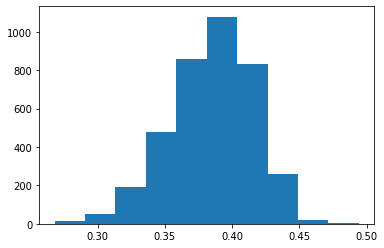

In [8]:
plt.hist(top_n.df_design['pred std'])

(array([ 5.,  6.,  8., 10., 19., 22.,  9.,  9.,  1.,  1.]),
 array([0.26797936, 0.28073132, 0.29348327, 0.30623522, 0.31898717,
        0.33173912, 0.34449107, 0.35724303, 0.36999498, 0.38274693,
        0.39549888]),
 <a list of 10 Patch objects>)

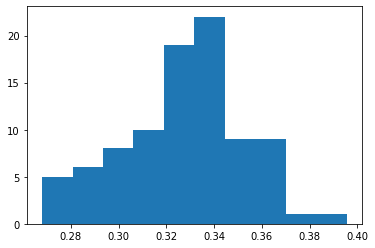

In [9]:
plt.hist(top_n_rec_df['pred std'])

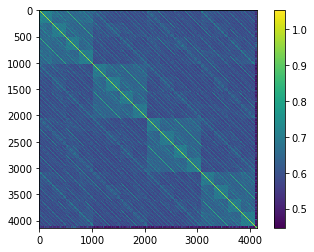

In [10]:
kernel_matrix = top_n.gpr.wd_kernel_instance.kernel_all_normalised
plt.imshow(kernel_matrix)
plt.colorbar()

## GP-BUCB

Desautels et al. 2014 Algorithm 2
http://jmlr.org/papers/volume15/desautels14a/desautels14a.pdf

In [11]:
gpbucb = GP_BUCB(known_df, kernel_name=kernel_name, l=l, s=s,sigma_0=sigma_0,
                 embedding=embedding, alpha=alpha, rec_size=rec_size, beta=beta, 
                 kernel_norm_flag=kernel_norm_flag, centering_flag = centering_flag, unit_norm_flag=unit_norm_flag)

In [12]:
gpbucb_rec_df = gpbucb.run_experiment()

0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (398, 28)
X train shape:  (2187, 20)
X test shape:  (3743, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (399, 28)
X train shape:  (2188, 20)
X test shape:  (3742, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (400, 28)
X train shape:  (2189, 20)
X test shape

## Recommendation results

In [13]:
gpbucb_rec_df

,index,AVERAGE,Group,Name,PERC,Plate,Pred Mean,Pred Std,Pred UCB,RBS,...,STD,Unnamed: 19,Unnamed: 20,Usable,idx,train_test,label,pred mean,pred std,ucb
0,1287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGACTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.730264,0.311727,1.353717
1,1316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGTGGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.691793,0.321573,1.334940
2,1279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGAGGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.769299,0.273908,1.317114
3,1289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGGTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.720371,0.280121,1.280612
4,1288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGGCTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.574294,0.348625,1.271544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,3193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGATGCGGATATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.315443,0.291616,0.898675
86,1318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGTGTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.277199,0.309636,0.896472
87,1330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCAATTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.322011,0.285851,0.893713
88,384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAAGCGGGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.241602,0.325109,0.891819


In [14]:
top_n_rec_df

,index,AVERAGE,Group,Name,PERC,Plate,Pred Mean,Pred Std,Pred UCB,RBS,...,STD,Unnamed: 19,Unnamed: 20,Usable,idx,train_test,label,pred mean,pred std,ucb
1645,1287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGACTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.730264,0.311727,1.353717
1674,1316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGTGGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.691793,0.321757,1.335307
1637,1279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGAGGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.769299,0.274431,1.318160
1647,1289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGGTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.720371,0.280871,1.282113
1646,1288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGGCTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.574294,0.350563,1.275420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1694,1336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCATGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.238301,0.335616,0.909532
742,384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAAGCGGGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.241602,0.333586,0.908773
1909,1551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGCCGAGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.244261,0.331875,0.908012
3551,3193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGATGCGGATATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.315443,0.295122,0.905688


In [15]:
top_n_rec_df.index

Int64Index([1645, 1674, 1637, 1647, 1646, 1696, 2531, 1698, 1718, 1606, 1644,
            1697, 3486, 1844, 1651,  683,  680, 3293, 1650, 1418, 1773, 1716,
            1695, 1406,  437, 3261, 1699, 1702, 3500, 1632, 1703,  711, 1602,
            3264, 1672, 1700, 1605, 1717, 3262, 3249, 2316,  771, 2314, 1673,
            1652, 1771, 1648, 2771,  681, 2303, 1452, 1608, 1719,  773, 1857,
            1656, 1726, 1639, 2542, 1704, 2575, 1604, 1675, 1689, 2783,  425,
             682, 1607, 3497, 1405,  912, 1684, 1912, 1701, 3260,  738, 1846,
            1724, 1772, 1676, 1690, 2084, 1855, 2543, 2313, 1694,  742, 1909,
            3551, 1419],
           dtype='int64')

### Similarity between recommendations

characterized by the same kernel used for prediction.

Text(0.5, 1.0, 'GP_BUCB hist')

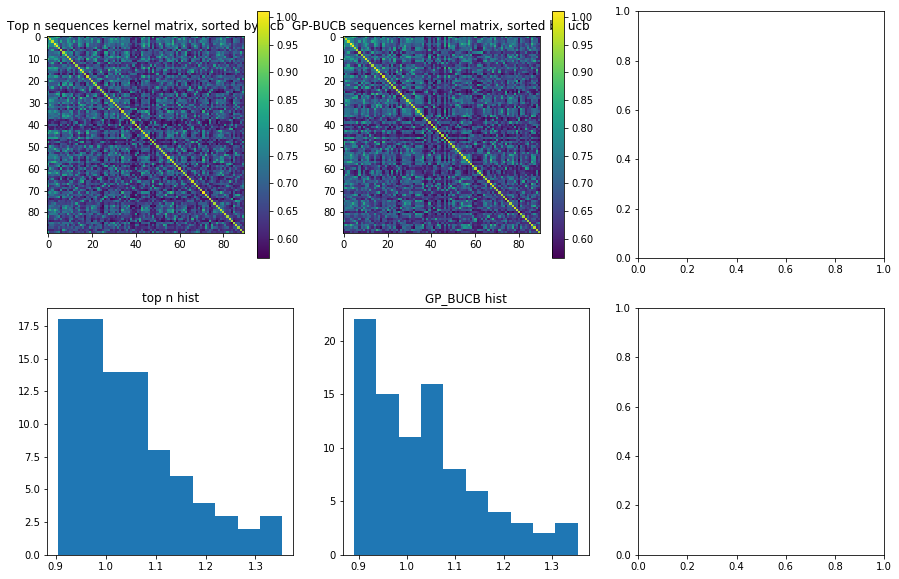

In [16]:
num_rows = 2
num_cols = 3

wd_kernel = WD_Shift_Kernel
fig,a = plt.subplots(num_rows, num_cols, figsize = (15,10))

wd_kernel.INIT_FLAG = False
im = a[0][0].imshow(top_n.gpr.wd_kernel_instance.__call__(np.asarray(top_n_rec_df['RBS'])), cmap = 'viridis')
fig.colorbar(im, ax =a[0][0])
a[0][0].set_title('Top n sequences kernel matrix, sorted by ucb')

wd_kernel.INIT_FLAG = False
im = a[0][1].imshow(gpbucb.gpr.wd_kernel_instance.__call__(np.asarray(gpbucb_rec_df['RBS'])), cmap = 'viridis')
fig.colorbar(im, ax =a[0][1])
a[0][1].set_title('GP-BUCB sequences kernel matrix, sorted by ucb')

# wd_kernel.INIT_FLAG = False
# all_features = np.concatenate((np.asarray(top_n_rec_df['RBS']), np.asarray(gpbucb_rec_df['RBS'])), axis = 0)
# im = a[0][2].imshow(wd_kernel(l=6, features = all_features).kernel_all_normalised, cmap = 'viridis')
# fig.colorbar(im, ax =a[0][2])
# a[0][2].set_title('Top n + GP-BUCB')

im = a[1][0].hist(top_n_rec_df['ucb'])
a[1][0].set_title('top n hist')

im = a[1][1].hist(gpbucb_rec_df['ucb'])
a[1][1].set_title('GP_BUCB hist')

# im = a[1][2].hist(gpbucb_rec_df['ucb'])
# a[1][2].set_title('GP_BUCB hist')

In [17]:
common_rec = set(top_n_rec_df['RBS']).intersection(set(gpbucb_rec_df['RBS']))
print('Number of intersection of recommendations: ', len(common_rec))

Number of intersection of recommendations:  88


In [19]:
para_name = '_alpha' + str(alpha) + '_beta' + str(beta) + 'kernelNorm' + str(kernel_norm_flag)

with pd.ExcelWriter('batch_ucb.xlsx', engine="openpyxl", mode='a') as writer:
    top_n_rec_df.to_excel(writer, sheet_name = 'top_n_core_' + para_name)
    gpbucb_rec_df.to_excel(writer, sheet_name = 'gpbucb_core_' + para_name)